In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import tweepy, json
from geopy.geocoders import Nominatim

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score

import re
import os
import numpy
import random
import string
import nltk
import time
from datetime import timedelta
from nltk.corpus import stopwords
from collections import defaultdict
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

import EngineFiles.TweetExtract as te
import EngineFiles.TweetFormat as tf
import EngineFiles.TweetVisualize as tv
import EngineFiles.TweetClean as tc
import EngineFiles.Word2Vec.word2vecModeling as w2v

%matplotlib inline
mpl.style.use('seaborn')

In [2]:
te.GenerateTweets(max_tweets_data=10000, keyword=['bangsat','agama','tenang','kafir','mantan','jablay','jokowi','umat','bangkit'])

All tweets already generated!


In [3]:
df = te.GetTweets()
df.to_csv(r'Data/indonesia_Tweet/empty_tweets.csv', index=False, header=True)
df.head(20)

text
1   Aku kenal bf 10 years, tak gaduh, marah, tingg...
2   RT @sacretzr: cewe ikut nongkrong bareng cowo ...
3   Biasanya Jokowi tdk birokratis &amp; formalist...
4   @jokowi Jokowi ngak mau kalah dengan Aceh, beb...
5   RT @msaid_didu: Ayo bersatu selamatkan negeri ...
6                             @edelweisnya ttp tenang
7   RT @mworkji: GURU AGAMA GUE GA JELAS BETUL MAS...
8   1 per 1 Pendukung JOKOWI Dan juga para Penista...
9   RT @msaid_didu: Ayo bersatu selamatkan negeri ...
10  gays gua lg bolos pelajaran agama, gaikut zoom...
11  Pukul empat sore kemarin, saya menerima telepo...
12  Pukul empat sore kemarin, saya menerima telepo...
14  RT @aizadfahmy: Chey Aiman Terpaling Psikologi...
15                 @awandasss Bangtot : bangsat total
16  JOKOWI REKAYASA PENANGKAPAN JOKO CANDRA/DJOKO ...
17                  @Kdaejn Tenang pasukan aq banyak😍
18  Kira - kira ..\nBerapa harga KARTU KEBAL HUKUM...
19             Yah mau gimana lagi gua gak dikangenin
20  @nahdlatululama \n@nahdlatululama_ \n@suaraNU ...
21  RT @aizadfahmy: Chey Aiman Terpaling Psikologi...

In [4]:
df = tf.main_data()

alay_lang = tf.bahasa_slang()
stopword_bahasa = tf.bahasa_stopwords(additional_words=['rt'])

display(df.head())

Tweet     label
0  - disaat semua cowok berusaha melacak perhatia...  negative
1  RT USER: USER siapa yang telat ngasih tau elu?...  negative
2  41. Kadang aku berfikir, kenapa aku tetap perc...  positive
3  USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...  positive
4  USER USER Kaum cebong kapir udah keliatan dong...  negative

---
# ANALYZING RAW DATA

In [5]:
print(df.info(), end='\n\n')
print(f'Dataset shape: {df.shape[0]} rows and {df.shape[1]} columns', end='\n')
display(df.groupby(['label']).count())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14210 entries, 0 to 1308
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   14210 non-null  object
 1   label   14210 non-null  object
dtypes: object(2)
memory usage: 333.0+ KB
None

Dataset shape: 14210 rows and 2 columns


Tweet
label          
negative   7636
positive   6574

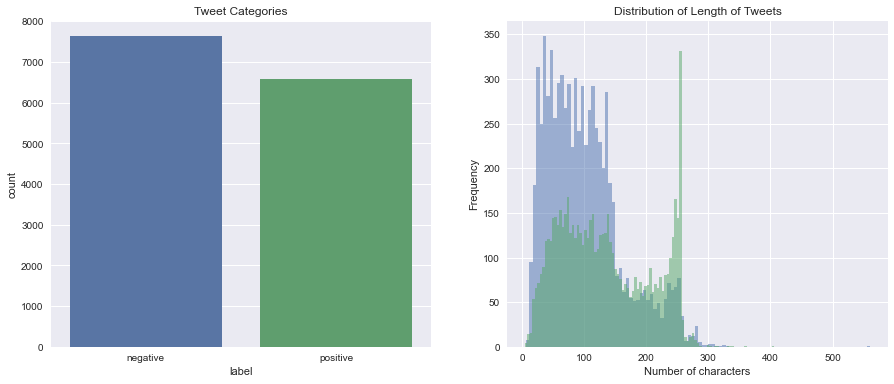

In [6]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
df1 = df[df['label']=='negative']['Tweet'].apply(len)
df2 = df[df['label']=='positive']['Tweet'].apply(len)

sns.countplot(x='label', data=df, ax=ax[0])
ax[0].set_title('Tweet Categories')
df1.plot(bins=100, kind='hist', ax=ax[1], alpha=0.5)
df2.plot(bins=100, kind='hist', ax=ax[1], alpha=0.5)
ax[1].set_title('Distribution of Length of Tweets')
ax[1].set_xlabel('Number of characters')
plt.show()

## Most frequent text appears

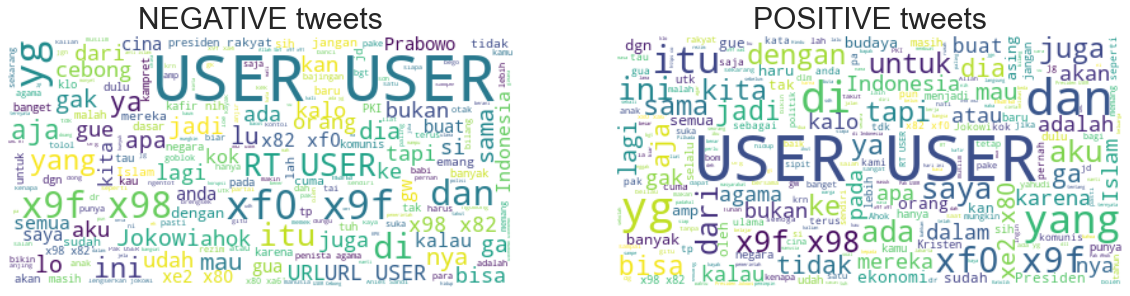

In [7]:
tv.wordcloud_viz(dataframe=df, col_labels='label', labels=['negative','positive'], col_target='Tweet', max_words=300)

---
# DATA CLEANING

## Lowering words

In [8]:
test_str = 'HeLLo ev3RyonE!!'
tc.get_low(test_str)

'hello ev3ryone!!'

## Removing punctuation

In [9]:
test_str= ":) Hii, everyone...!!"
tc.del_punc(test_str)

' Hii everyone'

## Removing uncommon words

In [10]:
test_str = '<a>Hi\teveryone, RT @UsEr ple\xf0se click this xf0x9fx98xa link <strong>https://www.bitly.com<strong>\n and http:www.google.com, enjoy you\x98r day</a>'
tc.del_dirty_words(test_str)

' a Hi everyone RT ple se click this xfxfxxa link strong and http enjoy you r day a '

## Replacing *'alay'* words

In [11]:
test_str = 'abisin ajalah biar gak ad lg yg megangin'
tc.replace_alay(test_str, alay_lang)

'habiskan sajalah biar tidak ada lagi yang memegang'

## Stemming words

In [12]:
test_str = 'Perekonomian Indonesia sedang dalam pertumbuhan yang membanggakan'
tc.stemming_words(test_str)

'ekonomi indonesia sedang dalam tumbuh yang bangga'

## Removing stopwords

In [13]:
test_str = 'Dengan Menggunakan Python dan Library Sastrawi saya dapat melakukan proses Stopword Removal'
tc.del_stopwords(test_str)

'Dengan Menggunakan Python Library Sastrawi proses Stopword Removal'

## Text Cleaning Pipeline

In [14]:
'''
OS : Windows 10 Pro 64bit
Processor : i7 6700K @ 4.00GHz
RAM : 32GB @ 1066MHz
Storage : NVMe SSD 512GB
'''
start_time = time.time()
df['Tweet'] = df['Tweet'].apply(lambda x : tc.text_preprocessing(x, alay_lang))
df.dropna(subset=['Tweet'],inplace=True)
finish_time = time.time()
print('Text cleaning process elapsed time: {}'.format(timedelta(seconds=finish_time-start_time)))

Text cleaning process elapsed time: 0:03:27.032551


In [15]:
df.to_csv(r'Data/indonesia_Tweet/clean_tweets.csv', index=False, header=True)

In [16]:
'''
OS : Windows 10 Pro 64bit
Processor : i7 6700K @ 4.00GHz
RAM : 32GB @ 1066MHz
Storage : NVMe SSD 512GB
'''
start_time = time.time()
with open('EngineFiles/Word2Vec/idwiki.txt', 'r', encoding='UTF-8') as f:
    idwiki = f.read()

idwiki = idwiki.split('\n')
idwiki_clean = []
for i in idwiki:
    cl_txt = tc.text_preprocessing(i, alay_lang)
    idwiki_clean.append(cl_txt)

idwiki_clean = '\n'.join(idwiki_clean)

with open('EngineFiles/Word2Vec/idwiki_clean.txt', 'w') as f:
    f.write(idwiki_clean)

finish_time = time.time()
print('idwiki dump cleaning process elapsed time: {}'.format(timedelta(seconds=finish_time-start_time)))

idwiki dump cleaning process elapsed time: 4:34:07.270777


In [17]:
df.head(10)

Tweet     label
0  cowok usaha lacak perhati gue lantas remeh per...  negative
1  rt telat tau edan sarap gue gaul cigax jifla c...  negative
2  kadang pikir percaya tuhan jatuh kali kali kad...  positive
3                               tau mata sipit lihat  positive
4          kaum cebong kafir lihat dongok dungu haha  negative
5                         ya bani taplak kawan kawan  negative
6  deklarasi pilih kepala daerah aman anti hoaks ...  positive
7  gue selesai re watch aldnoah zero kampret kara...  negative
8  admin belanja port nak makan ais kepal milo ai...  positive
9                                         enak ngewe  negative

---
# EXPLORATORY DATA ANALYSIS

## Number of Characters & Words in Each Tweet

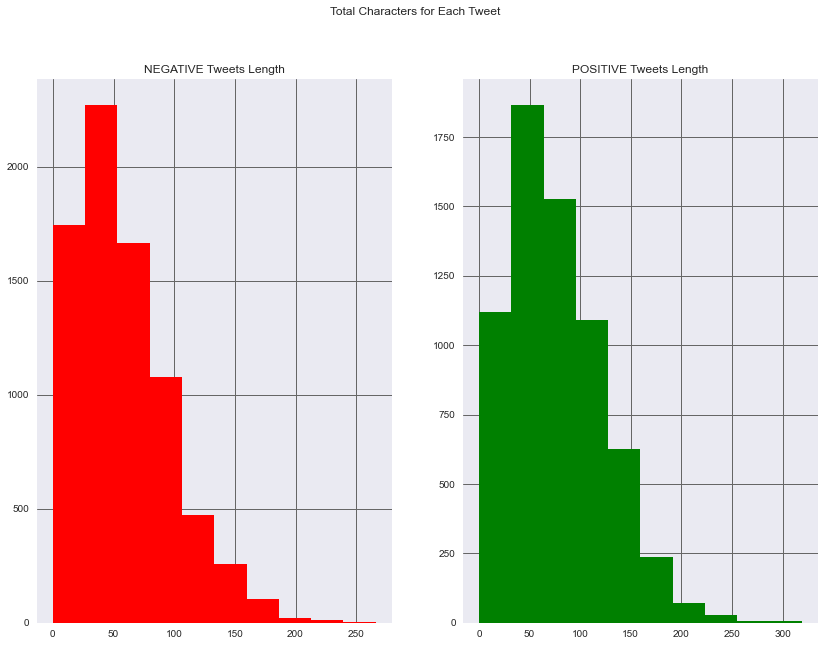

In [18]:
tv.words_and_chars_in_tweet(dataframe=df, col_labels='label', labels=['negative','positive'], target='Tweet', color=['red', 'green'], generate='char')

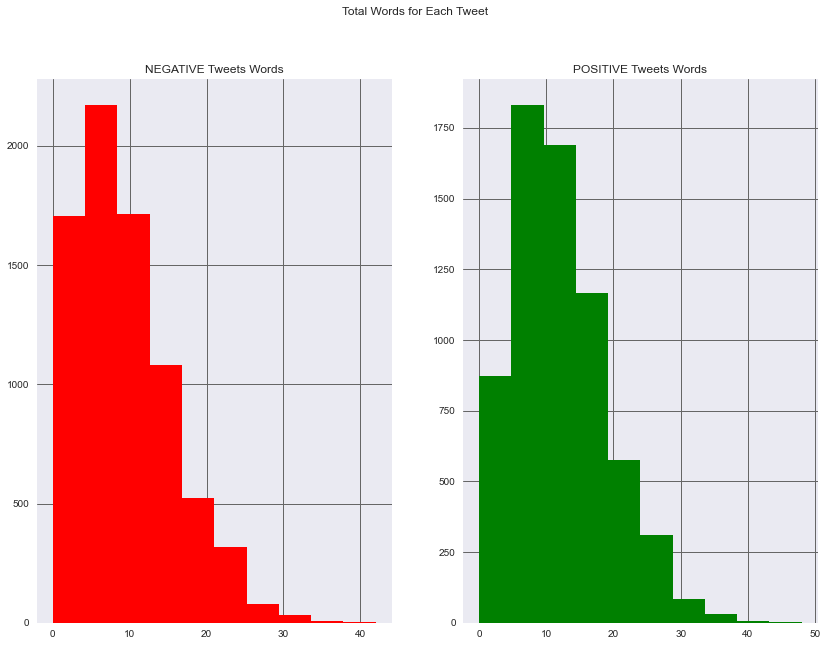

In [19]:
tv.words_and_chars_in_tweet(dataframe=df, col_labels='label', labels=['negative','positive'], target='Tweet', color=['red', 'green'],generate='word')

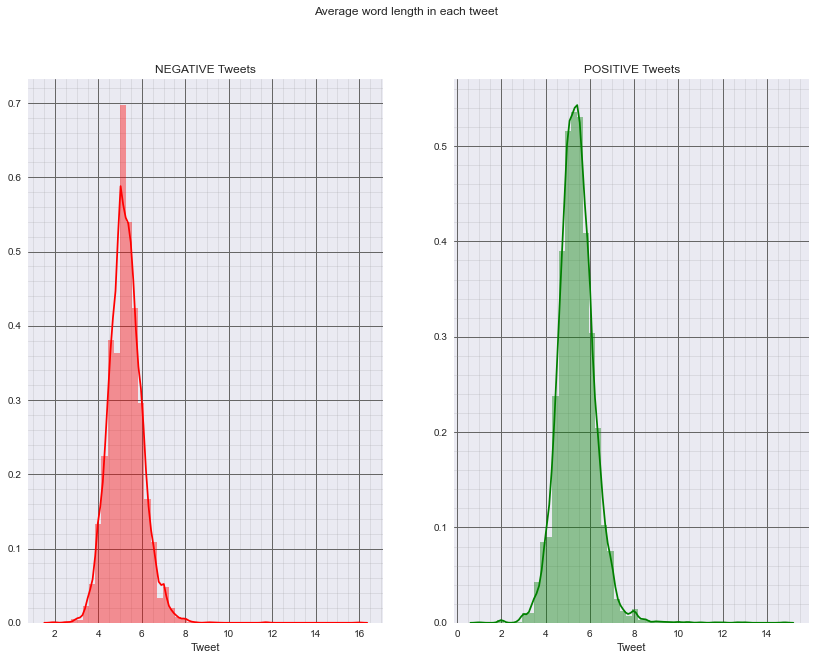

In [20]:
tv.words_and_chars_in_tweet(dataframe=df, col_labels='label', labels=['negative','positive'], target='Tweet', color=['red', 'green'],generate='avg')

## Unigrams

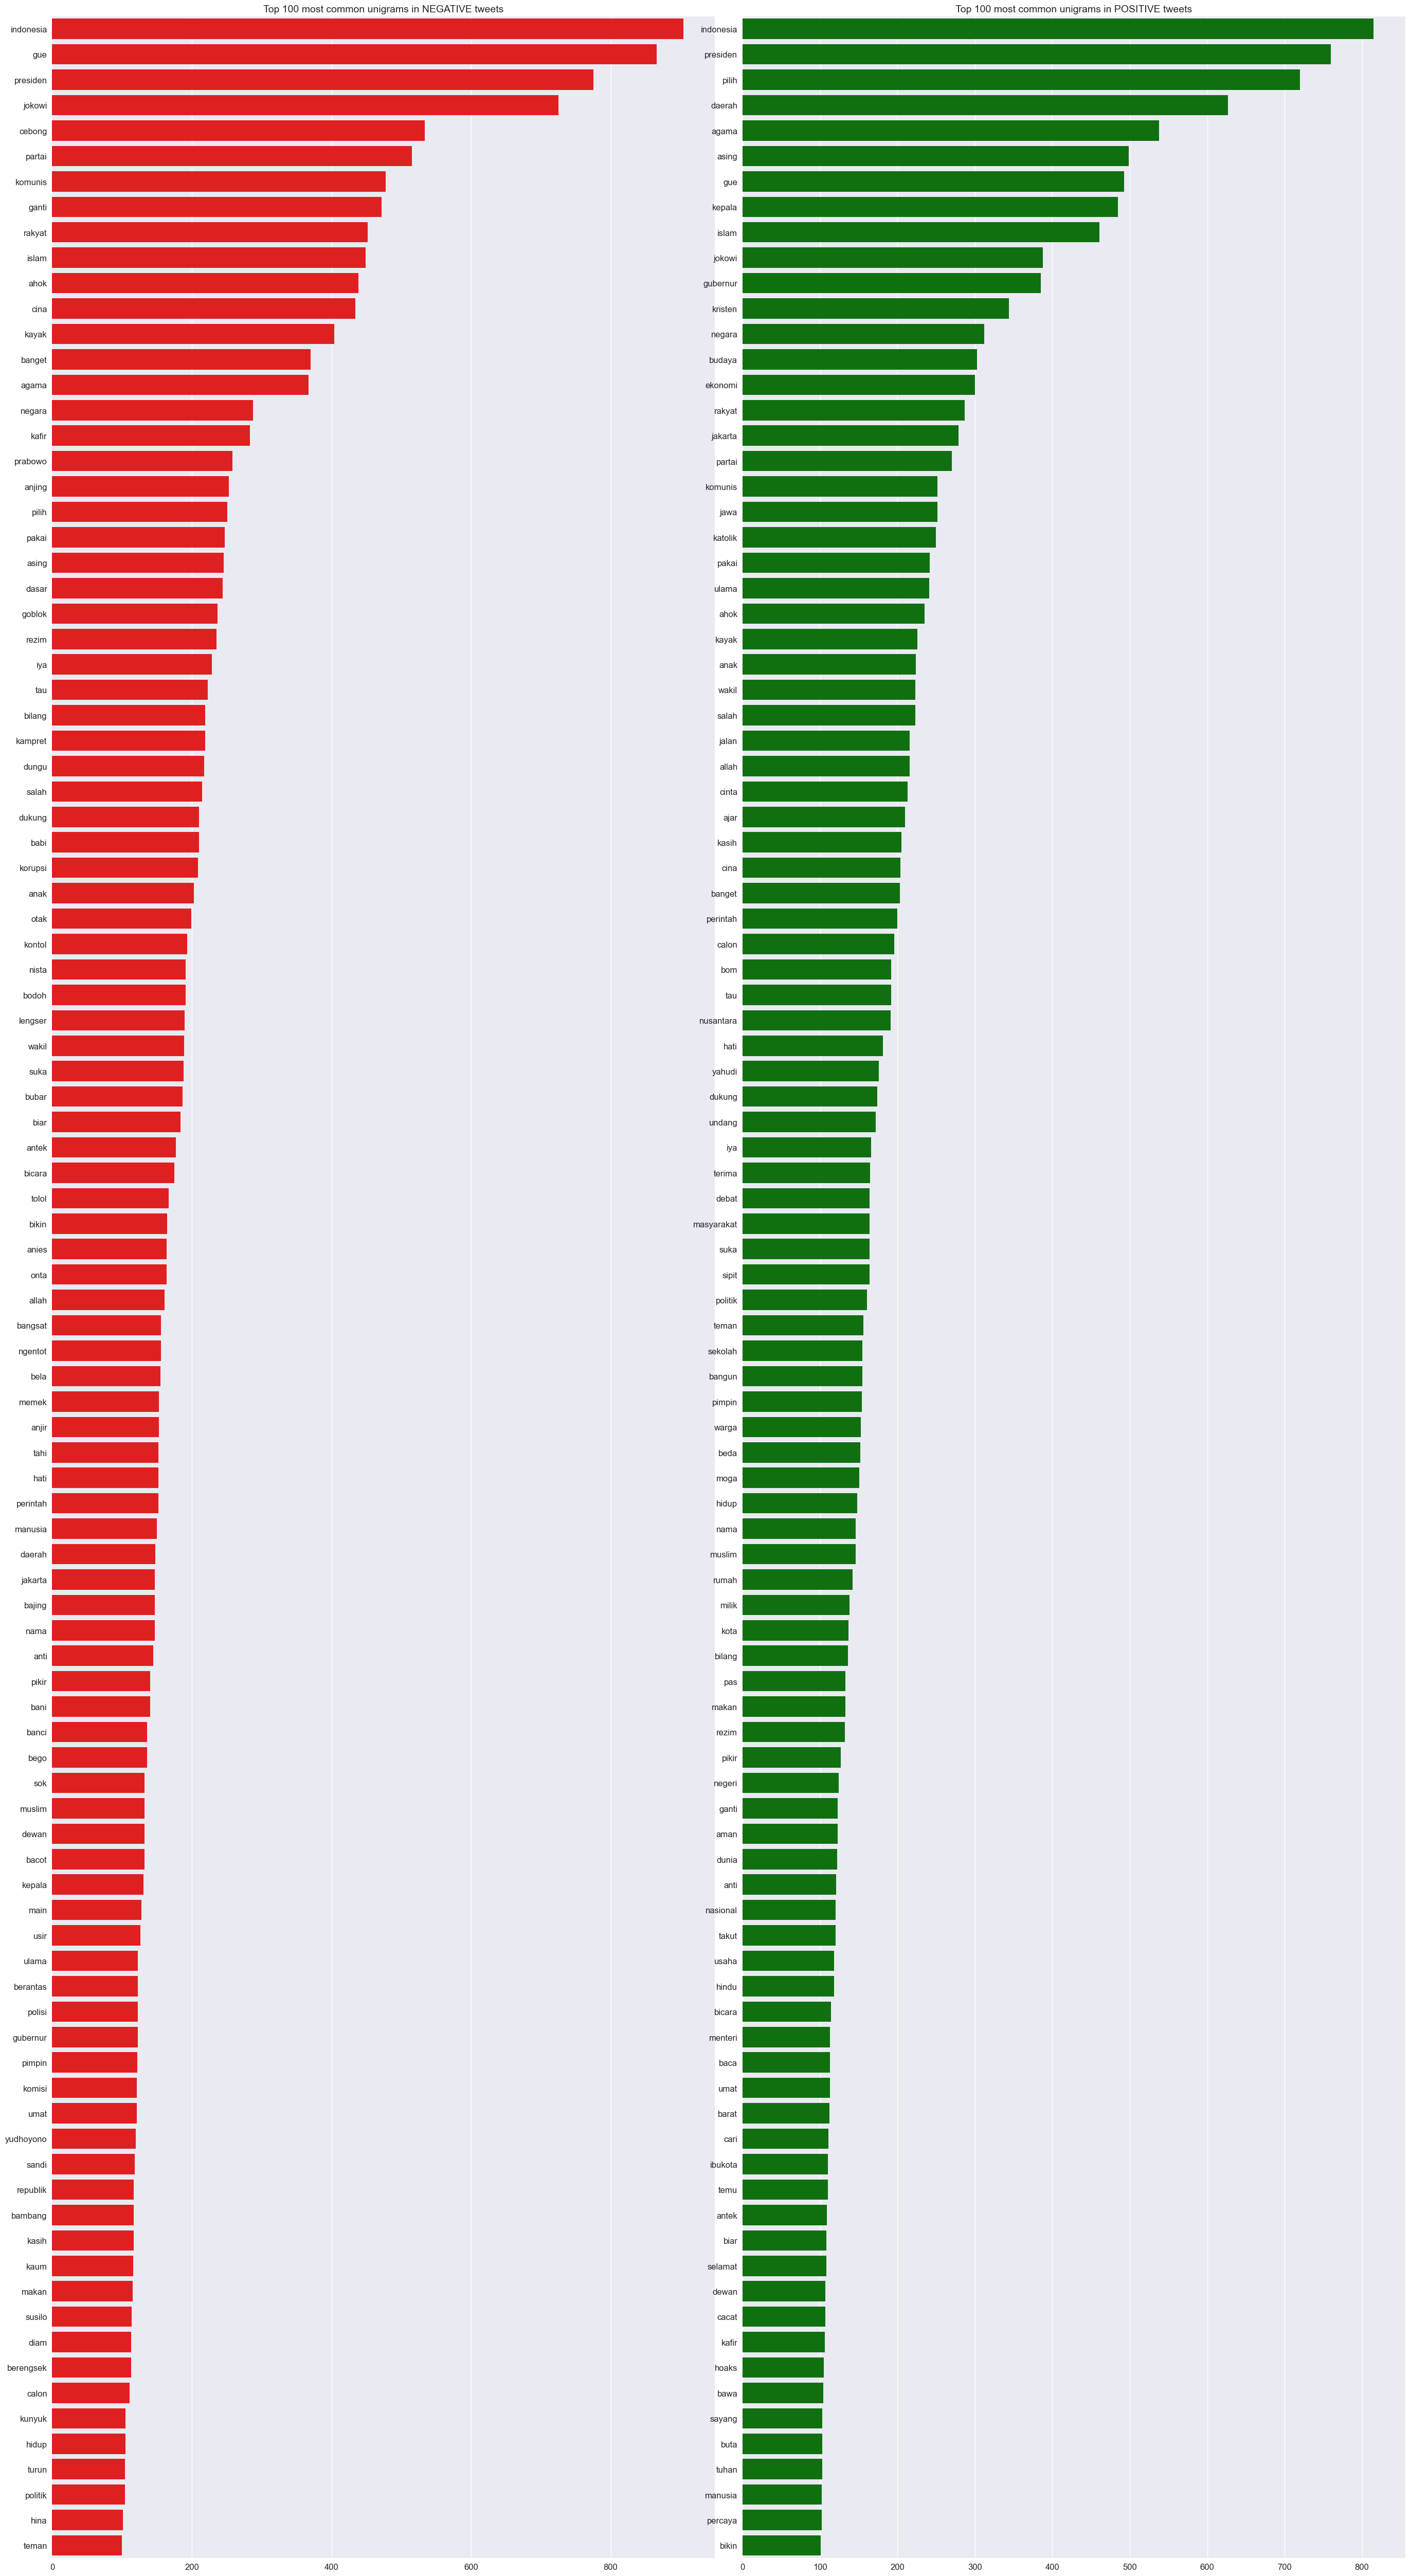

In [21]:
tv.ngrams_viz(dataframe=df, col_labels='label', labels=['negative','positive'], col_target='Tweet', ngrams=1, max_words=100, stopwords_list=stopword_bahasa)

## Bigrams

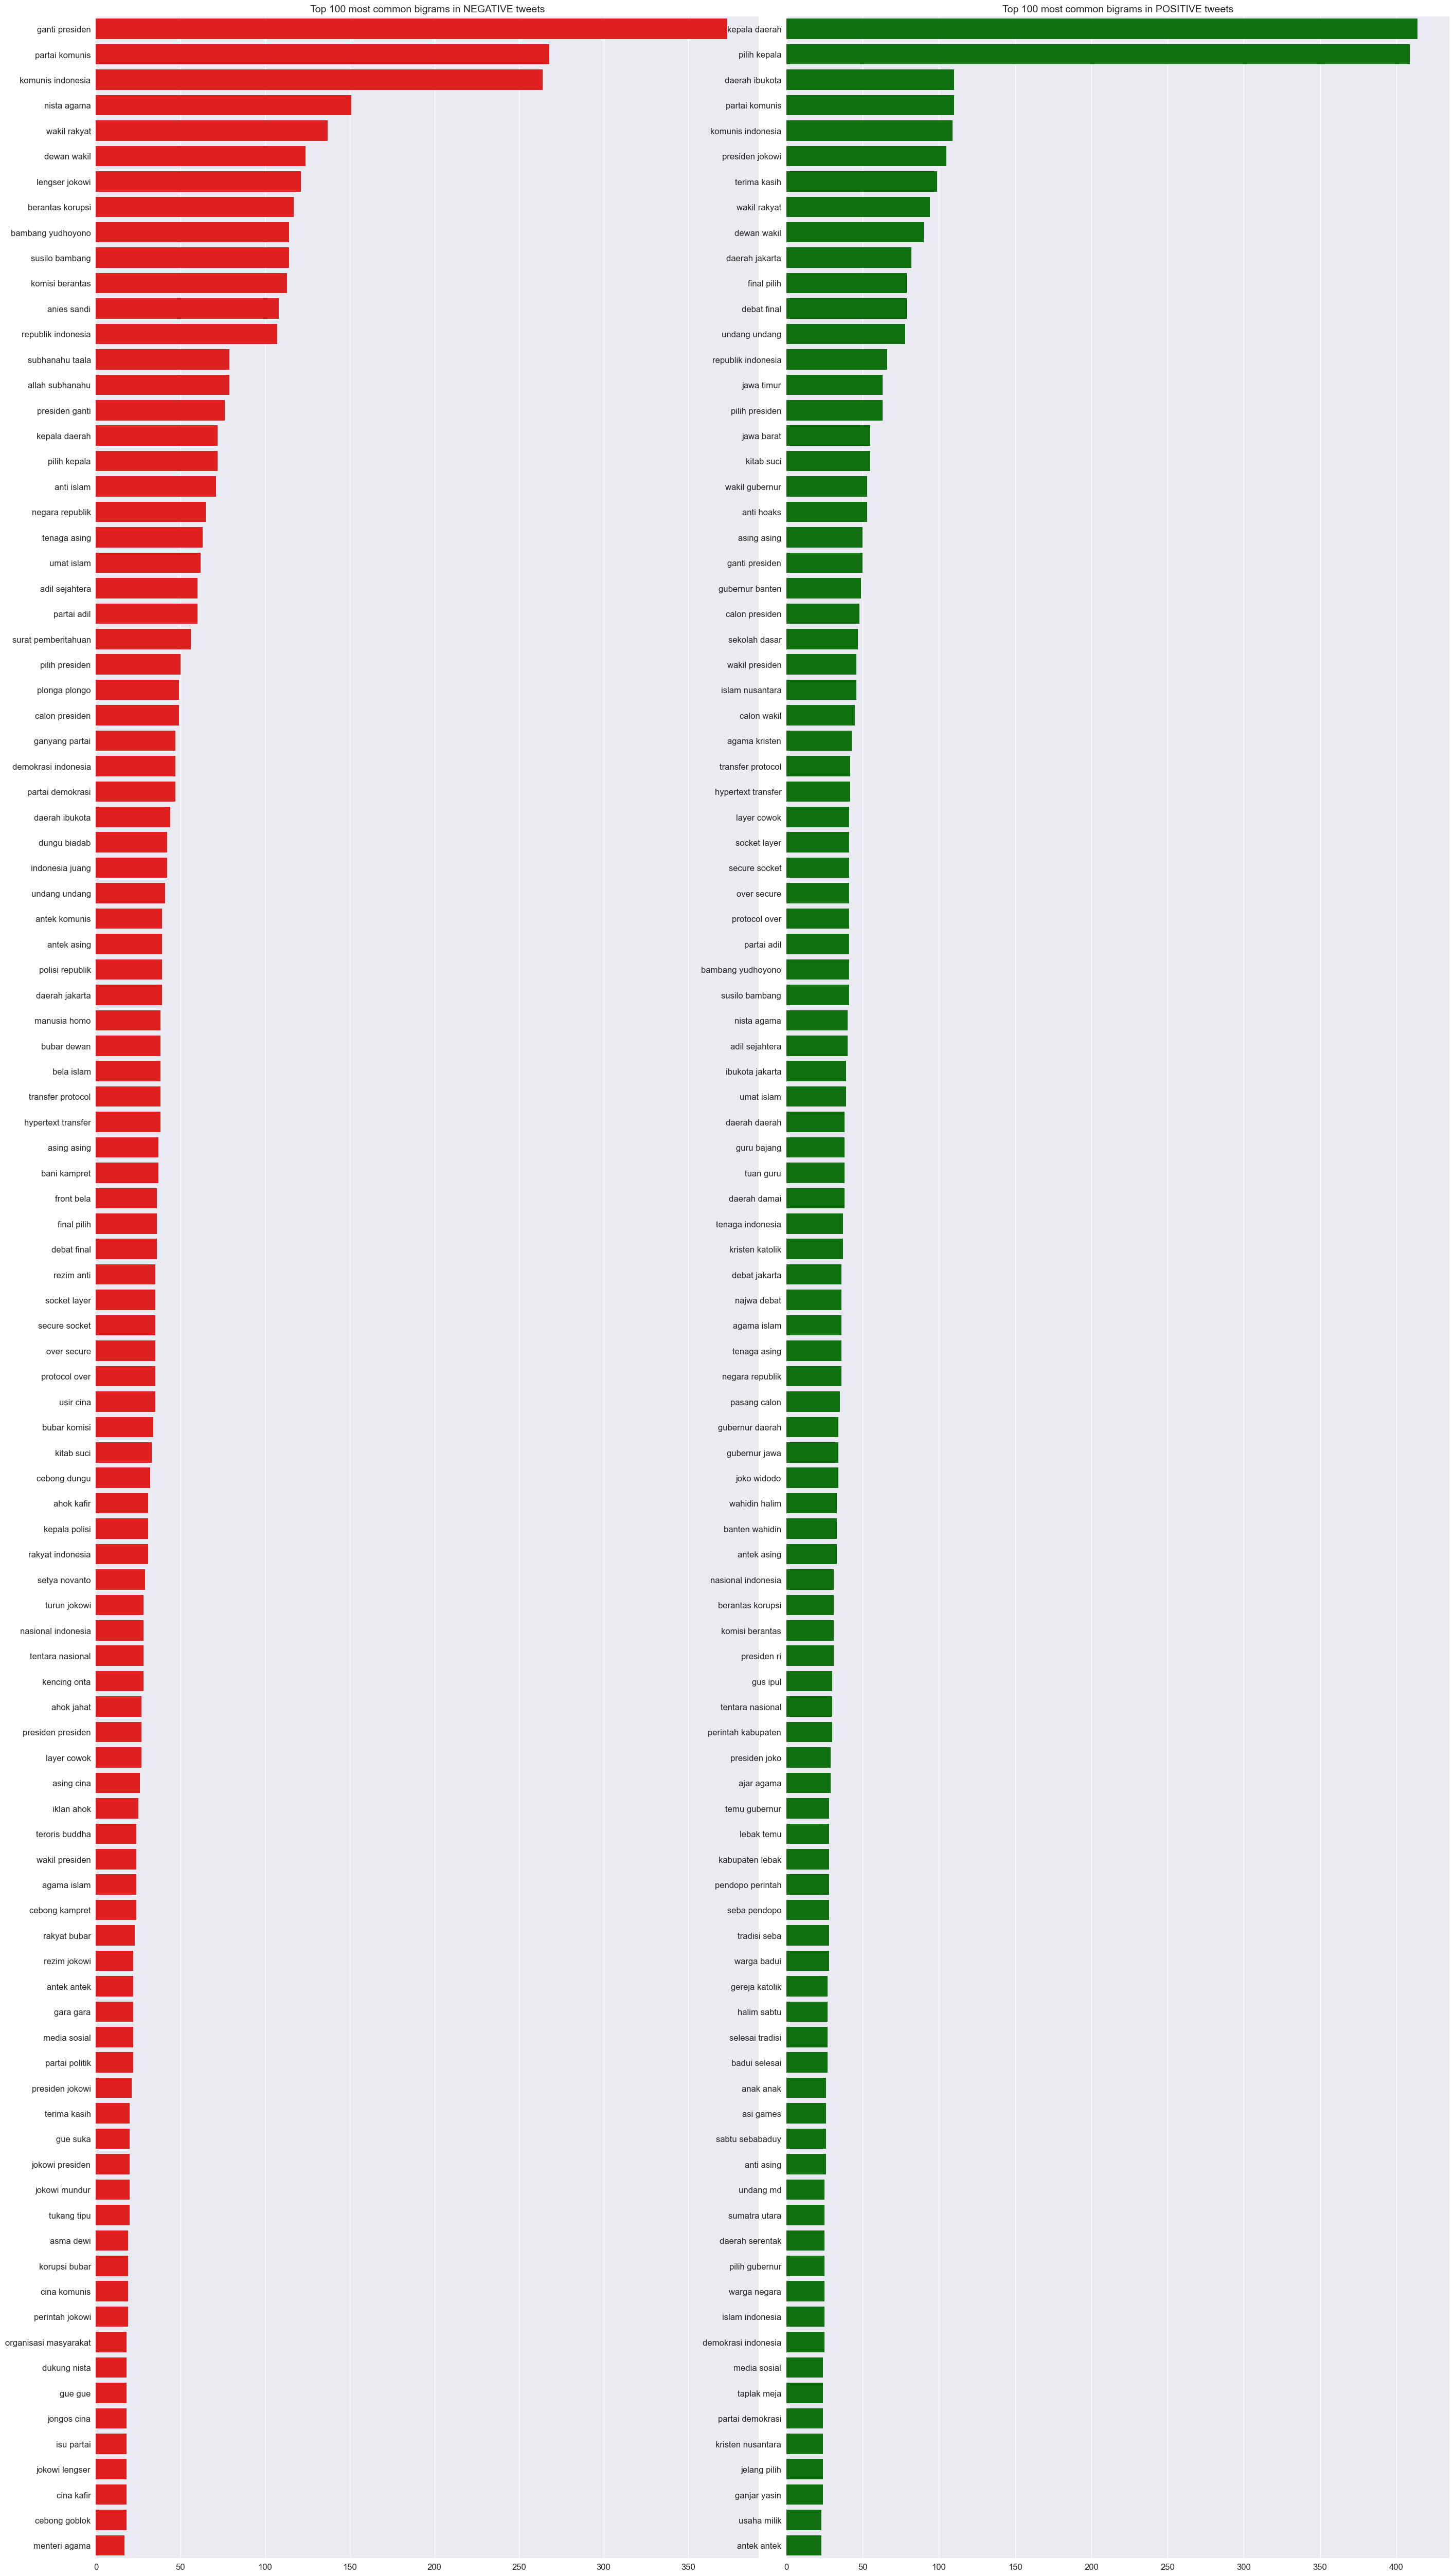

In [22]:
tv.ngrams_viz(dataframe=df, col_labels='label', labels=['negative','positive'], col_target='Tweet', ngrams=2, max_words=100, stopwords_list=stopword_bahasa)

## Trigrams

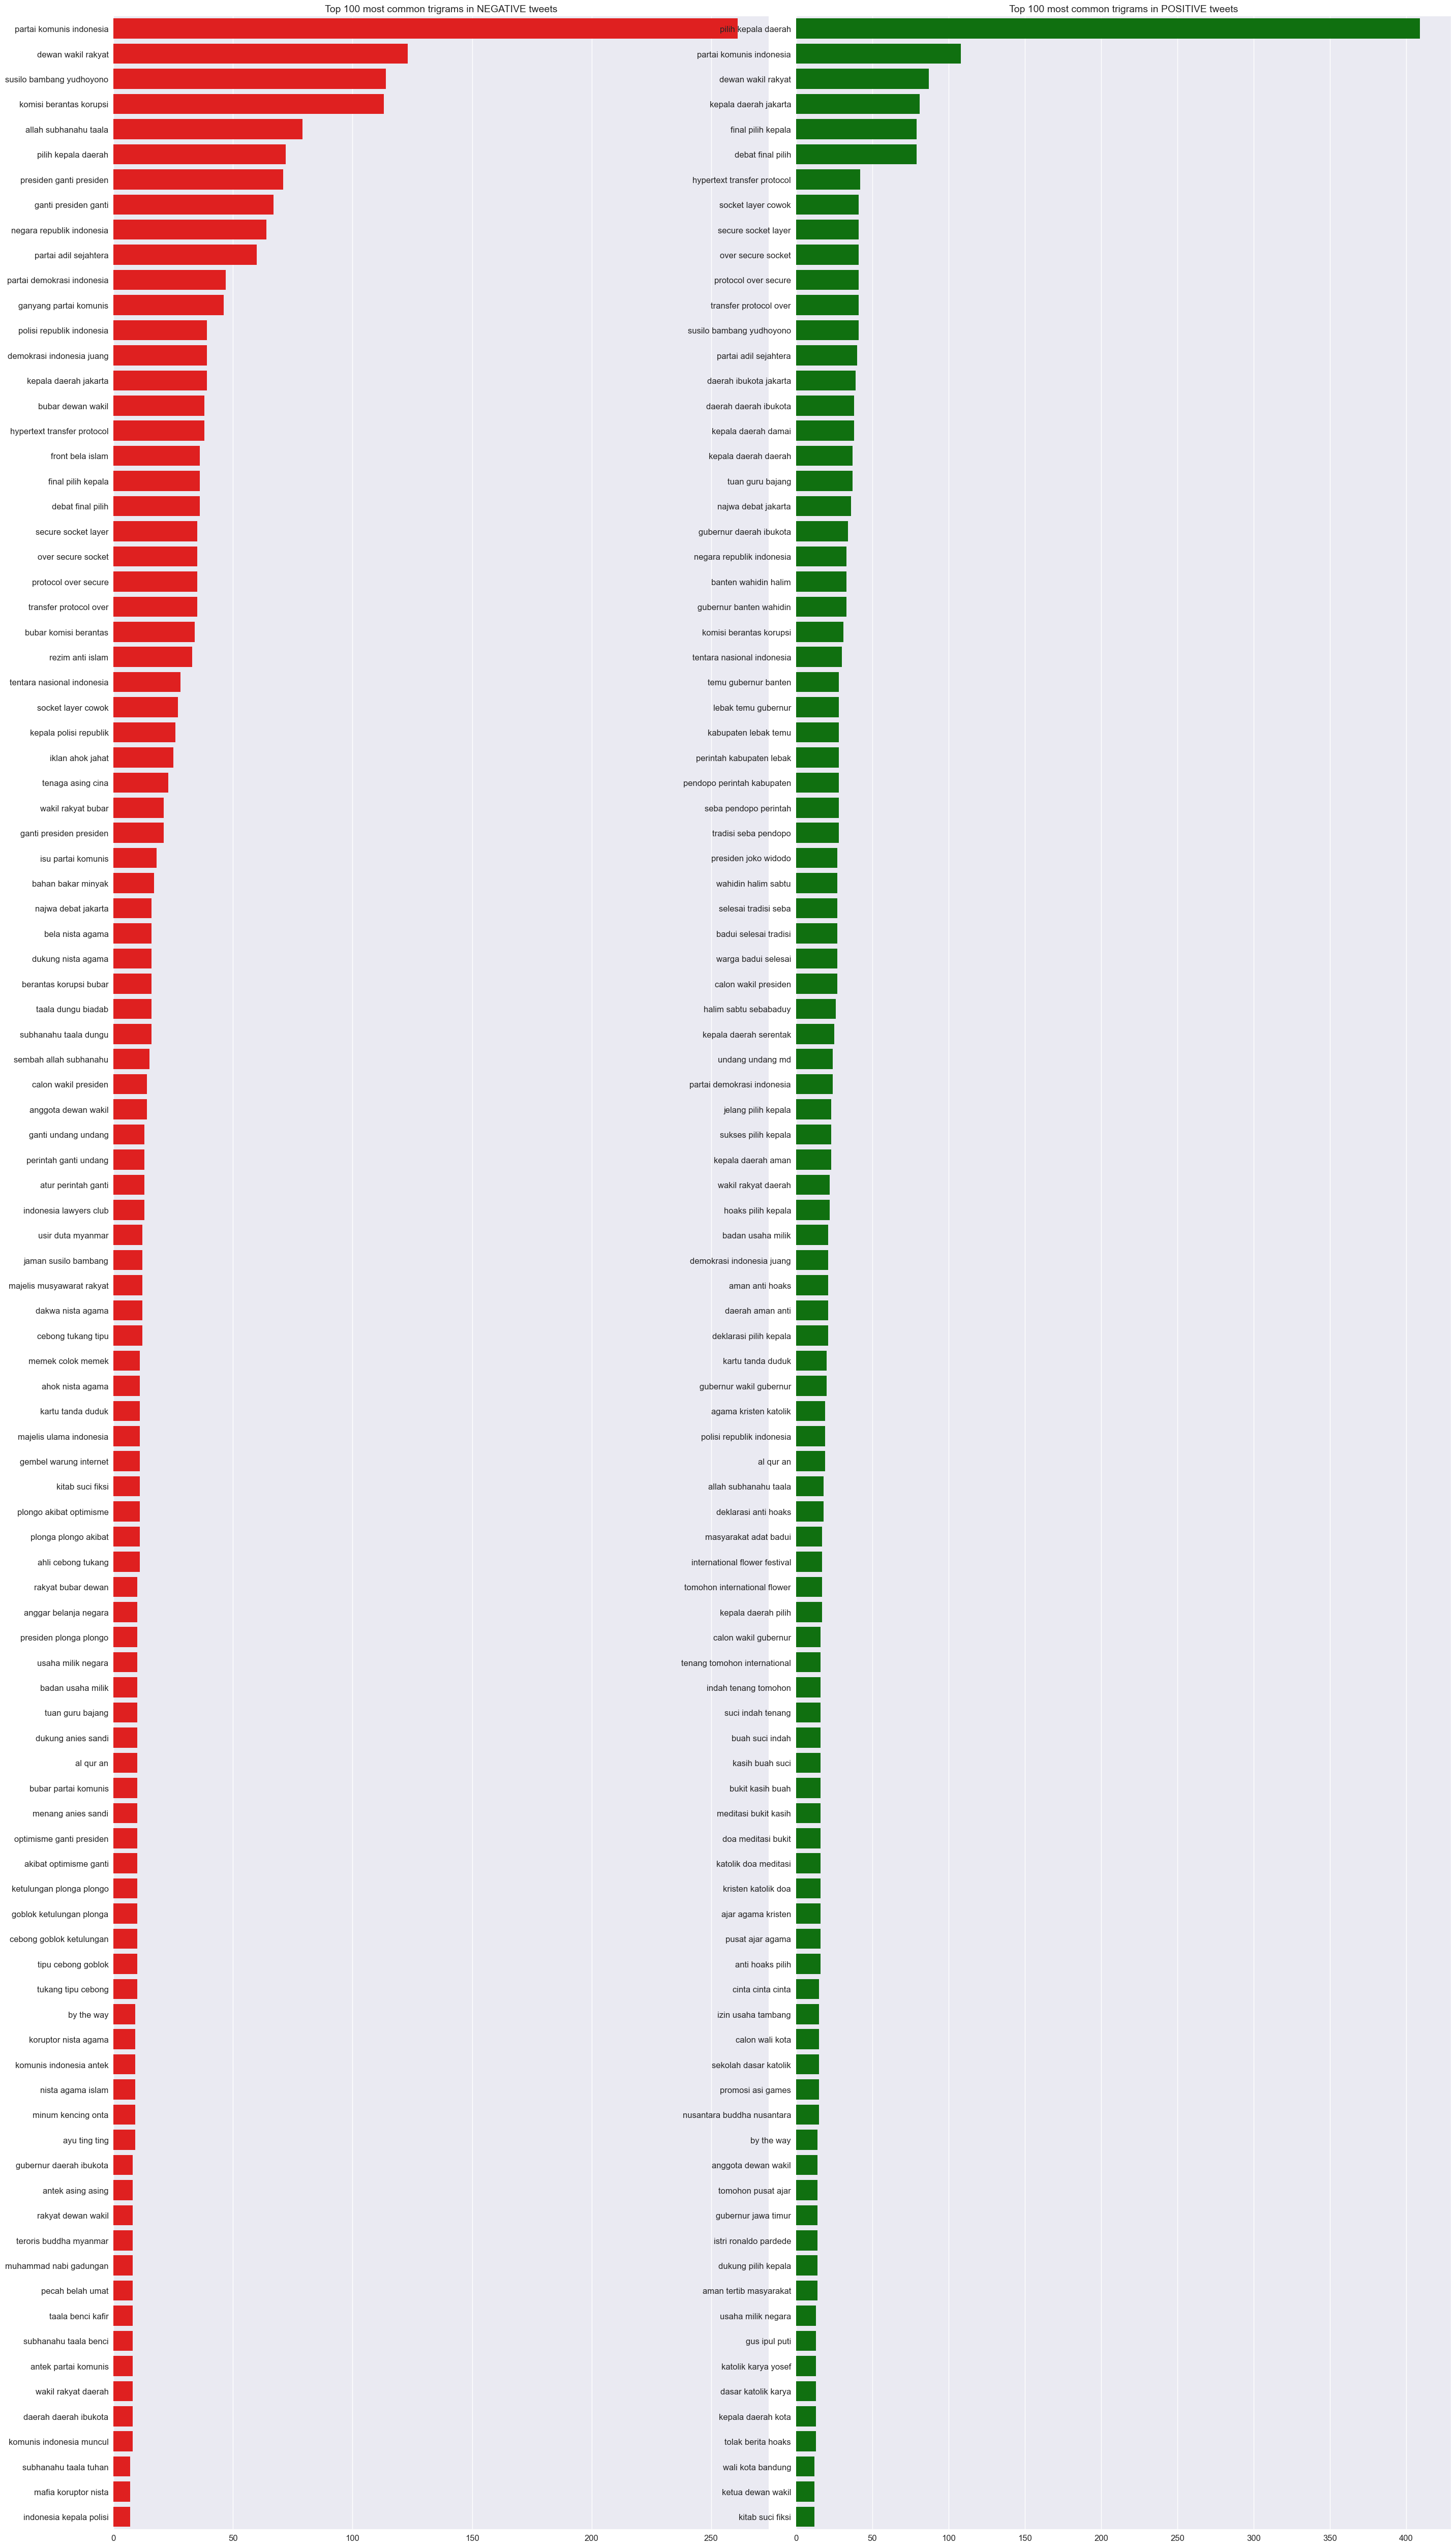

In [23]:
tv.ngrams_viz(dataframe=df, col_labels='label', labels=['negative','positive'], col_target='Tweet', ngrams=3, max_words=100, stopwords_list=stopword_bahasa)

## WordCloud

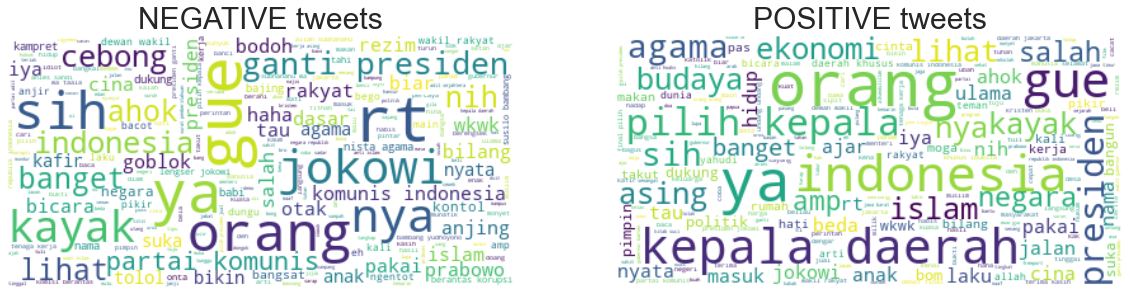

In [24]:
tv.wordcloud_viz(dataframe=df, col_labels='label', labels=['negative','positive'], col_target='Tweet', max_words=300)

---
# WORDS PROCESSING (Word2Vec Model with Gensim)

## Build Word2Vec Model

In [14]:
w2v.GenerateWikiData()

Streaming Wiki corpus Bahasa...
10000 articles processed
20000 articles processed
30000 articles processed
40000 articles processed
50000 articles processed
60000 articles processed
70000 articles processed
80000 articles processed
90000 articles processed
100000 articles processed
110000 articles processed
120000 articles processed
130000 articles processed
140000 articles processed
150000 articles processed
160000 articles processed
170000 articles processed
180000 articles processed
190000 articles processed
200000 articles processed
210000 articles processed
220000 articles processed
230000 articles processed
240000 articles processed
250000 articles processed
260000 articles processed
270000 articles processed
280000 articles processed
290000 articles processed
300000 articles processed
310000 articles processed
320000 articles processed
330000 articles processed
340000 articles processed
350000 articles processed
360000 articles processed
370000 articles processed
380000 articles

In [14]:
w2v.TrainModel(dataframe=df, tweet_column='Tweet', model_name='idtwitter_word2vec_200')

Training Word2Vec model...
Finished. Elapsed time : 0:11:34.244391

Model is saved in EngineFiles/Word2Vec/model/idtwitter_word2vec_200.model directory


## Load pre-Trained Word2Vec Model

In [21]:
w2v_model = w2v.GetModel(model_name='idtwitter_word2vec_200')

In [22]:
len(w2v_model.wv.vocab)

377828

In [65]:
df_copy = df.copy()
# df_copy['negative'] = df_copy['label'].apply(lambda x : 1 if x == 'negative' else 0)
# df_copy['positive'] = df_copy['label'].apply(lambda x : 1 if x == 'positive' else 0)
df_copy['category'] = df_copy['label'].apply(lambda x : 1 if x == 'positive' else 0)
df_copy.drop('label', axis=1, inplace=True)

X = []

for s in list(df_copy['Tweet']):
    X.append(s)

# label_tweets = df_copy[['negative', 'positive']]
# y = label_tweets.values
# y = df_copy[['category']].values

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

'''
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break
'''

'''
plt.hist([len(x) for x in X], bins=10)
plt.show()
'''

vocab_size = len(tokenizer.word_index) + 1

# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 200))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        try:
            weight_matrix[i] = model[word]
        except KeyError:
            continue
    return weight_matrix

#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, word_index)

#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=200, weights=[embedding_vectors], trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# ===================================================================================
# deep_inputs = Input(shape=(200,))
# embedding_layer = Embedding(vocab_size, 200, weights=[embedding_vectors], trainable=False)(deep_inputs)
# LSTM_Layer_1 = LSTM(128)(embedding_layer)
# dense_layer_1 = Dense(1, activation='sigmoid')(LSTM_Layer_1)
# model = Model(inputs=deep_inputs, outputs=dense_layer_1)

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# ===================================================================================
# model = models.Sequential()
# model.add(Dense(512, activation='relu', input_shape=(200,)))
# model.add(Dense(512, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# ===================================================================================

'''
print(model.summary())
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
'''

X_train, X_test, y_train, y_test = train_test_split(X, df_copy['category'], test_size=0.2, random_state=42, stratify= df_copy.category.values)

X_train = pad_sequences(X_train, padding='post', maxlen=200)
X_test = pad_sequences(X_test, padding='post', maxlen=200)

history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
66/66 [==============================] - 29s 437ms/step - loss: 0.6883 - acc: 0.5554 - val_loss: 0.6876 - val_acc: 0.5534
Epoch 2/5
66/66 [==============================] - 29s 438ms/step - loss: 0.6871 - acc: 0.5554 - val_loss: 0.6878 - val_acc: 0.5534
Epoch 3/5
66/66 [==============================] - 28s 421ms/step - loss: 0.6874 - acc: 0.5554 - val_loss: 0.6874 - val_acc: 0.5534
Epoch 4/5
66/66 [==============================] - 29s 441ms/step - loss: 0.6873 - acc: 0.5554 - val_loss: 0.6875 - val_acc: 0.5534
Epoch 5/5
66/66 [==============================] - 27s 412ms/step - loss: 0.6872 - acc: 0.5554 - val_loss: 0.6874 - val_acc: 0.5534


In [48]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

83/83 [==============================] - 0s 1ms/step - loss: 17.3405 - accuracy: 0.5752
Test Score: 17.34054183959961
Test Accuracy: 0.5751708149909973


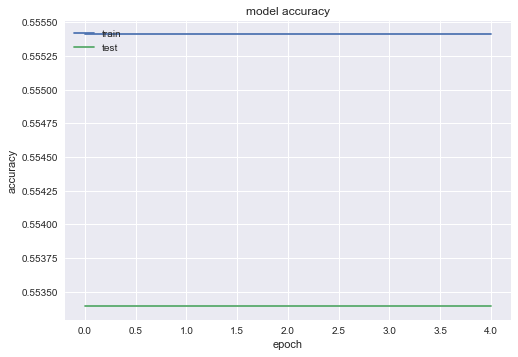

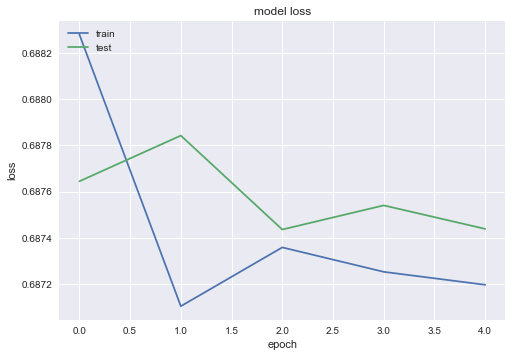

In [96]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Vectorizing Tweet Column Into New DataFrame

In [24]:
w2v_df = w2v.vectorize_tweet(word2vec_model=w2v_model, dataframe=df, tweet_column='Tweet')

In [25]:
w2v_df.head()

0         1         2         3         4         5         6    \
0 -0.698047 -0.614234  0.335342  0.371780 -0.078662  0.111038 -0.327808   
1 -0.083930 -0.922935  0.046591  0.476717  0.020280  0.399080 -0.568050   
2  0.325732  0.779624  0.609089  0.557621 -0.626185  0.014681 -0.435796   
3 -0.051614 -0.914199  0.132087  0.405769 -0.692033  0.264976 -1.007067   
4  0.525119  0.854075  1.066023  0.326857  0.229797  0.742537 -0.373480   

        7         8         9    ...       190       191       192       193  \
0  0.203642  0.058548  0.662691  ...  0.470541  0.394793  0.287899  0.946504   
1  0.464700 -0.124549  0.465161  ...  0.465944  0.156977  0.051806  0.776210   
2 -0.485184  0.382615  0.964828  ...  0.020892  1.791081  0.246010  0.095843   
3  0.829818 -0.692156  0.628475  ...  0.657514  0.390473 -0.667770  0.992132   
4 -0.064822  0.786007  1.095250  ...  0.095772  1.322461  0.343392 -0.394170   

        194       195       196       197       198       199  
0  0.510494 -0.099428 -0.224773  0.261205 -0.920121  0.531304  
1  0.594172  0.143069 -0.561306  0.106013 -0.441357  0.341470  
2  0.127352  0.653268 -0.105289  1.122658 -0.786467  0.652071  
3  1.178999  0.224797  0.244267  0.600741 -0.016272  0.355346  
4  0.043378  1.372578 -0.040465  0.317554 -0.170116  0.967419  

[5 rows x 200 columns]

## Splitting Dataset into Train and Test

In [71]:
from sklearn.model_selection import train_test_split

# df_copy = df.copy()
# df_copy['category'] = df_copy['label'].apply(lambda x : 1 if x == 'positive' else 0)

x_train, x_test, y_train, y_test = train_test_split(w2v_df, df['label'], test_size=0.2, random_state=42, stratify= df_copy.label.values)
y_train = y_train.map({'negative':0, 'positive':1})
y_test = y_test.map({'negative':0, 'positive':1})

In [72]:
df_test = df.copy()
df_test['type'] = ['not_set'] * df_test.shape[0]
df_test.loc[y_train.index, 'type'] = 'train'
df_test.loc[y_test.index, 'type'] = 'test'
df_test.groupby(['label', 'type']).count()

Tweet
label    type        
negative test    1462
         train   5847
positive test    1172
         train   4688

---
# BUILD KERAS MODEL WITH SEQUENTIAL ALGORITM APPROACH

In [73]:
import tensorflow as tf
import keras.layers as layers
from keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Embedding, Dense, Flatten
from sklearn.metrics import accuracy_score, classification_report, f1_score
from keras import models

In [89]:
model = models.Sequential()
model.add(Dense(512, activation='relu', input_shape=(200,)))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print(model.summary())

Epoch 1/30
9/9 [==============================] - 0s 29ms/step - loss: 0.6298 - acc: 0.6468 - val_loss: 0.5663 - val_acc: 0.7105
Epoch 2/30
9/9 [==============================] - 0s 18ms/step - loss: 0.5419 - acc: 0.7364 - val_loss: 0.5225 - val_acc: 0.7451
Epoch 3/30
9/9 [==============================] - 0s 19ms/step - loss: 0.4968 - acc: 0.7663 - val_loss: 0.5041 - val_acc: 0.7613
Epoch 4/30
9/9 [==============================] - 0s 25ms/step - loss: 0.4618 - acc: 0.7843 - val_loss: 0.4873 - val_acc: 0.7746
Epoch 5/30
9/9 [==============================] - 0s 19ms/step - loss: 0.4326 - acc: 0.8029 - val_loss: 0.4915 - val_acc: 0.7750
Epoch 6/30
9/9 [==============================] - 0s 21ms/step - loss: 0.4082 - acc: 0.8211 - val_loss: 0.4853 - val_acc: 0.7784
Epoch 7/30
9/9 [==============================] - 0s 19ms/step - loss: 0.3833 - acc: 0.8281 - val_loss: 0.4799 - val_acc: 0.7731
Epoch 8/30
9/9 [==============================] - 0s 19ms/step - loss: 0.3572 - acc: 0.8491 - val

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [90]:
history = model.fit(x_train, y_train, epochs=30, batch_size=1024, validation_split=0.2)

83/83 [==============================] - 0s 1ms/step - loss: 0.9650 - acc: 0.7699
Test Score: 0.9650123715400696
Test Accuracy: 0.7699316740036011


In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [91]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 512)               102912    
_________________________________________________________________
dense_40 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 513       
Total params: 366,081
Trainable params: 366,081
Non-trainable params: 0
_________________________________________________________________
None


In [92]:
predict = model.predict(x_test)
predict = np.array([0 if i<0.5 else 1 for i in predict])
predict

array([0, 0, 0, ..., 1, 0, 0])

In [93]:
f1_score(y_test, predict)

0.7328042328042327

In [94]:
accuracy_score(y_test, predict)

0.7699316628701595

In [95]:
print(classification_report(y_test, predict))

precision    recall  f1-score   support

           0       0.78      0.82      0.80      1462
           1       0.76      0.71      0.73      1172

    accuracy                           0.77      2634
   macro avg       0.77      0.76      0.77      2634
weighted avg       0.77      0.77      0.77      2634

